<a href="https://colab.research.google.com/github/katharine-brudkiewicz/Ultrasound-CV-CNN-Phase-Aberration-Correction/blob/main/CVCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#CV-CNN Script
#Import Data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import gc
import scipy.io as sio

with open('/content/drive/MyDrive/rf2.pkl','rb') as f:  # Python 3: open(..., 'rb')
   das = pickle.load(f)

mas = []
for x in range (4584):
  if "x2" in das[x]:
    mas.append(das[x]['x2'])
  if "x22" in das[x]:
    mas.append(das[x]['x22'])






In [6]:
mas[1].shape

(282, 64)

In [7]:
#Prep data into ndarray
for x in range (4584):
  mas[x]=mas[x][0:256,0:64]
data_das = np.array(mas)
data_das.shape
del das
del mas

gc.collect()

15

In [8]:
with open('/content/drive/MyDrive/l2.pkl','rb') as f:  # Python 3: open(..., 'rb')
   label = pickle.load(f)


In [9]:
mas = []
for x in range (4584):
  if "sos2" in label[x]:
    mas.append(label[x]['sos2'])
  if "sos22" in label[x]:
    mas.append(label[x]['sos22'])




In [10]:
mas[1].shape

(400, 200)

In [11]:
#
for x in range (4584):
  mas[x]=mas[x][0:400,0:200]
label_das = np.array(mas)
label_das.shape
del label
del mas

gc.collect()

6

In [12]:
# Install the necessary complex-valued neural network repository
!pip install cvnn
!pip install tensorflow-addons


In [13]:

import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import cvnn.layers as complex_layers

In [14]:

data_das = np.squeeze(data_das)
data_das.shape

(4584, 256, 64)

In [15]:

label_das = np.squeeze(label_das)
label_das.shape

(4584, 400, 200)

In [ ]:
#display data and label, in this case: IQ signal and corresponding speed of sound map
n =20
for i in range(3000, 3020):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('Data')
    im0 = axes[0].imshow(abs(data_das[i]).reshape(256, 64), cmap = 'Reds')
    axes[1].set_title('Label')
    im1 = axes[1].imshow(abs(label_das[i]).reshape(400, 200), cmap = 'Reds')

In [ ]:
#some further processing to get data and label into matching dimensions
from skimage.transform import resize
dimension_1 = data_das.shape[1]
dimension_2 = data_das.shape[2]
dimension_11 = label_das.shape[1]
dimension_22 = label_das.shape[2]

B = np.zeros((4584,128,64),dtype=np.complex_)
C = np.zeros((4584,128,64),dtype=np.complex_)

for i in range(0,4584):
    x = resize(label_das[i], (128,64))
    B[i] = x

for i in range(0,4584):
    x = (np.delete(data_das[i], slice(0, 28), axis=0))
    x = (np.delete(x, slice(128, 228), axis=0))

    C[i] = x


for i in range(3000, 3020):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('Data')
    im0 = axes[0].imshow(abs(C[i]).reshape(128, 64), cmap = 'Reds')
    axes[1].set_title('Label')
    im1 = axes[1].imshow(abs(B[i]).reshape(128, 64), cmap = 'Reds')

In [ ]:
del data_das


gc.collect()

In [19]:
#data and labels split into training and testing and randomised
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(C,B, random_state=22)


In [20]:
del C
del label_das
gc.collect()

6

In [21]:
#remove nans
x_test = np.nan_to_num(x_test)
x_train = np.nan_to_num(x_train)
y_test = np.nan_to_num(y_test)
y_train = np.nan_to_num(y_train)


In [22]:
#store dimension size
dimension_1 = x_train.shape[1]
dimension_2 = x_train.shape[2]
dimension_11 = y_train.shape[1]
dimension_22 = y_train.shape[2]
len(x_train)

3438

In [23]:
#reshape data into tensor
x_train = np.reshape(x_train, (len(x_train), dimension_1, dimension_2, 1))
x_test = np.reshape(x_test, (len(x_test), dimension_1, dimension_2, 1))
y_train = np.reshape(y_train, (len(y_train), dimension_11, dimension_22, 1))
y_test = np.reshape(y_test, (len(y_test), dimension_11, dimension_22, 1))

In [ ]:
#display data
n = 20
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('Data')
    im0 = axes[0].imshow(abs(x_test[i]).reshape(dimension_1, dimension_2), cmap = 'Reds')
    axes[1].set_title('Label')
    im1 = axes[1].imshow(abs(y_test[i]).reshape(dimension_11, dimension_22), cmap = 'Reds')

In [25]:
x_test.shape

(1146, 128, 64, 1)

In [28]:
#architecture 1
from cvnn.activations import cart_leaky_relu
import cvnn
initializer = cvnn.initializers.ComplexHeNormal()
def autoencoder():
  input = complex_layers.complex_input(shape=(128, 64, 1))

  l1 = complex_layers.ComplexConv2D(64, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input)
  l2 = complex_layers.ComplexConv2D(64, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
  l3 = complex_layers.ComplexMaxPooling2D(padding='same')(l2)

  l4 = complex_layers.ComplexConv2D(128, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
  l5 = complex_layers.ComplexConv2D(128, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
  l6 = complex_layers.ComplexMaxPooling2D(padding='same')(l5)

  l7 = complex_layers.ComplexConv2D(256, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

  l8 = complex_layers.ComplexUpSampling2D()(l7)
  l9 = complex_layers.ComplexConv2D(128, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
  l10 = complex_layers.ComplexConv2D(128, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)


  l11 = tf.keras.layers.add([l10, l5])

  l12 = complex_layers.ComplexUpSampling2D()(l11)
  l13 = complex_layers.ComplexConv2D(64, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
  l14 = complex_layers.ComplexConv2D(64, (3, 3), padding='same', kernel_initializer=initializer, activation='crelu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)


  l15 = tf.keras.layers.add([l14, l2])

  decoded = complex_layers.ComplexConv2D(1, (3, 3), padding='same', kernel_initializer=initializer, activation='convert_to_real_with_abs', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

  return keras.models.Model(inputs=(input), outputs=decoded)
model =autoencoder()


In [27]:
#architecture 2
from cvnn.activations import cart_leaky_relu
import cvnn
initializer = cvnn.initializers.ComplexHeNormal()

def u_net_model():
  num_classes = 1
  inputs = complex_layers.complex_input(shape=(dimension_1,dimension_2,1))
  #Contraction path
  c1 = complex_layers.ComplexConv2D(16, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(inputs)
  c1 = complex_layers.ComplexDropout(0.1)(c1)
  c1 = complex_layers.ComplexConv2D(16, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(c1)
  b1 = complex_layers.ComplexBatchNormalization()(c1)
  r1 = cart_leaky_relu(b1)
  p1 = complex_layers.ComplexMaxPooling2D((2, 2))(r1)

  c2 = complex_layers.ComplexConv2D(32, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(p1)
  c2 = complex_layers.ComplexDropout(0.1)(c2)
  c2 = complex_layers.ComplexConv2D(32, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(c2)
  b2 = complex_layers.ComplexBatchNormalization()(c2)
  r2 = cart_leaky_relu(b2)
  p2 = complex_layers.ComplexMaxPooling2D((2, 2))(r2)

  c3 = complex_layers.ComplexConv2D(64, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(p2)
  c3 = complex_layers.ComplexDropout(0.2)(c3)
  c3 = complex_layers.ComplexConv2D(64, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(c3)
  b3 = complex_layers.ComplexBatchNormalization()(c3)
  r3 = cart_leaky_relu(b3)
  p3 = complex_layers.ComplexMaxPooling2D((2, 2))(r3)

  c4 = complex_layers.ComplexConv2D(128, (3, 3), activation= cart_leaky_relu, kernel_initializer=initializer, padding='same')(p3)
  c4 = complex_layers.ComplexDropout(0.2)(c4)
  c4 = complex_layers.ComplexConv2D(128, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(c4)
  b4 = complex_layers.ComplexBatchNormalization()(c4)
  r4 = cart_leaky_relu(b4)
  p4 = complex_layers.ComplexMaxPooling2D(pool_size=(2, 2))(r4)

  c5 = complex_layers.ComplexConv2D(256, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(p4)
  b5 = complex_layers.ComplexBatchNormalization()(c5)
  r5 = cart_leaky_relu(b5)
  c5 = complex_layers.ComplexDropout(0.3)(r5)
  c5 = complex_layers.ComplexConv2D(256, (3, 3), activation=cart_leaky_relu, kernel_initializer=initializer, padding='same')(c5)

  #Expansive path
  u6 = complex_layers.ComplexConv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  u6 = complex_layers.ComplexBatchNormalization()(u6)
  u6 = cart_leaky_relu(u6)


  u7 = complex_layers.ComplexConv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  u7 = complex_layers.ComplexBatchNormalization()(u7)
  u7 = cart_leaky_relu(u7)


  u8 = complex_layers.ComplexConv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  u8 = complex_layers.ComplexBatchNormalization()(u8)
  u8 = cart_leaky_relu(u8)

  u9 = complex_layers.ComplexConv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  u9 = complex_layers.ComplexBatchNormalization()(u9)
  u9 = cart_leaky_relu(u9)


  outputs = complex_layers.ComplexConv2D(num_classes, (1, 1), activation='convert_to_real_with_abs')(u9)
  return tf.keras.Model(inputs, outputs)

model = u_net_model()


In [29]:
#SSIM and PSNR loss functions
def ssim_loss(y_true, y_pred):

    ssim = tf.image.ssim(y_true, y_pred, max_val=1)

    return tf.math.subtract(tf.constant(1.0), ssim)


def psnr_loss(y_true, y_pred):

    psnr = tf.image.psnr(y_true, y_pred, max_val=1)

    return -psnr

In [30]:
#Compile CV-CNN model

from cvnn.losses import ComplexMeanSquareError
model.compile(loss=[ComplexMeanSquareError(),ssim_loss] , optimizer="adam", metrics=["mean_squared_error",ssim_loss,psnr_loss])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (ComplexInput)         [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 complex_conv2d_16 (ComplexConv  (None, 128, 64, 64)  1280       ['input_3[0][0]']                
 2D)                                                                                              
                                                                                                  
 complex_conv2d_17 (ComplexConv  (None, 128, 64, 64)  73856      ['complex_conv2d_16[0][0]']      
 2D)                                                                                        

In [ ]:
#train CV-CNN model
from cvnn.losses import ComplexMeanSquareError

validation_split = 0.8


new_history = model.fit(x_train, y_train, epochs = 20, batch_size = 10, shuffle = True, validation_split = validation_split)

In [ ]:
#define history keys
new_history.history.keys()

In [34]:
train_loss = new_history.history['loss']
train_val_loss = new_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

In [ ]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('historyabf1.png')

In [36]:
#generate predictions with test data
all_denoised_images = model.predict(x_test)


36/36 [==============================] - 47s 1s/step


In [37]:
del y_train
del x_train
gc.collect()
cvscores =[]

In [ ]:
#evaluate model performance on test data
test_loss  = model.evaluate(x_test, y_test, batch_size = 20)
print("%s: %.2f%%" % (model.metrics_names[1], test_loss[1]*100))
cvscores.append(test_loss[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
test_loss

In [ ]:
smse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
all = smse(y_test, model.predict(x_test)).numpy()

In [ ]:
all.std()

In [ ]:
all.mean()

<ipython-input-53-db2bac16a5a6>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3)


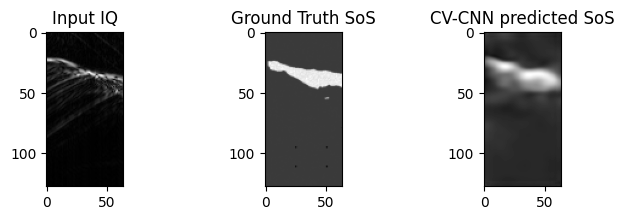

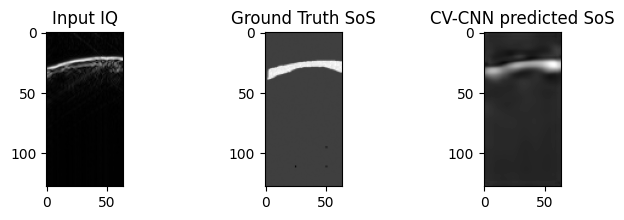

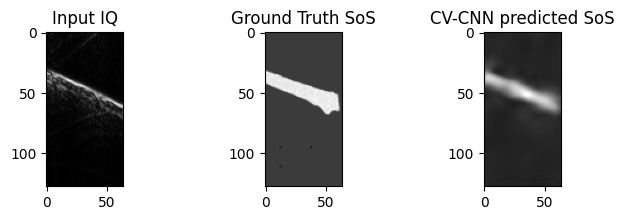

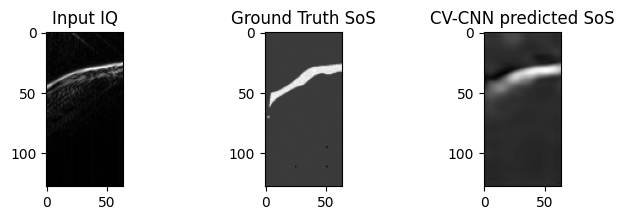

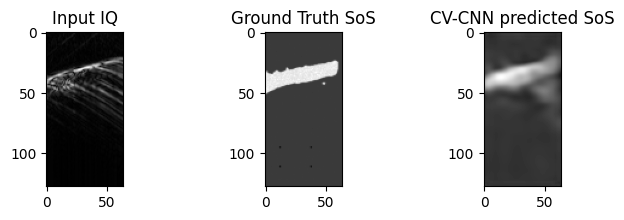

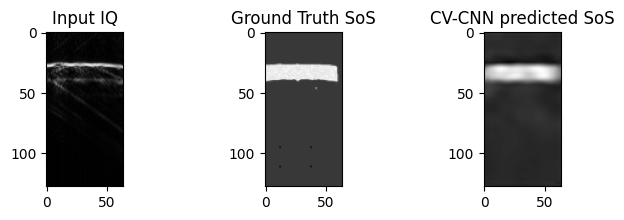

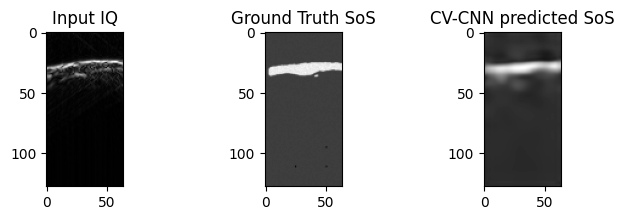

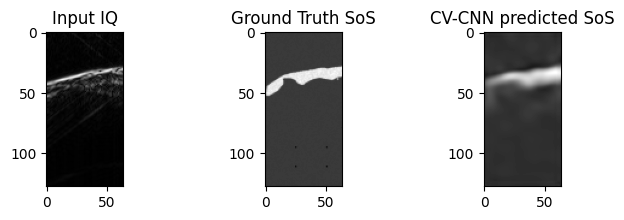

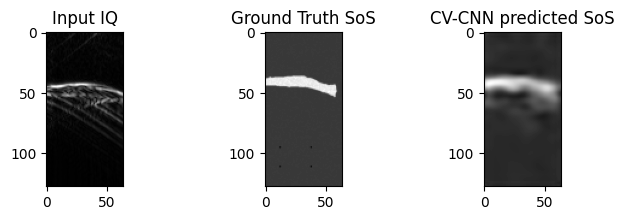

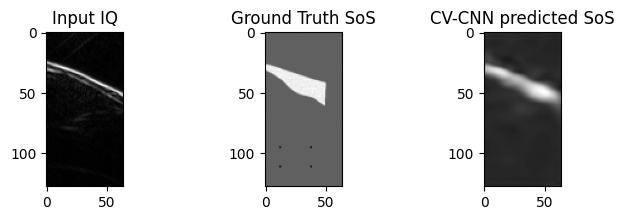

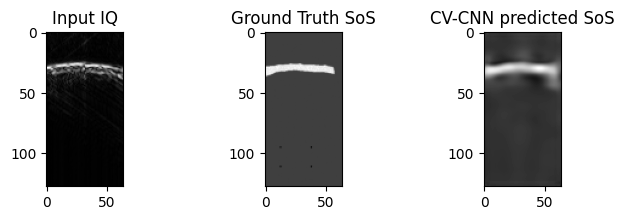

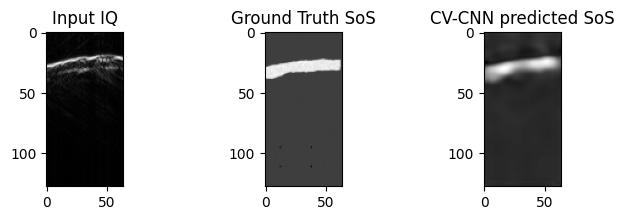

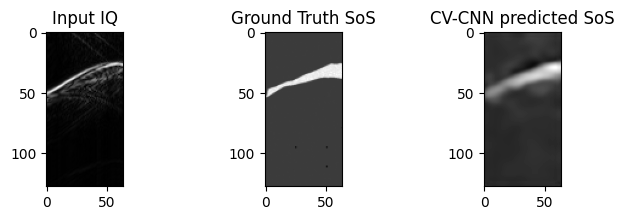

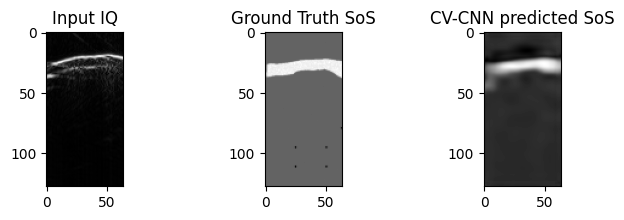

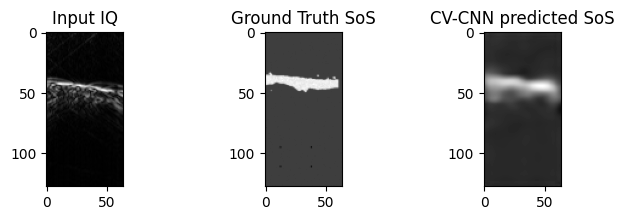

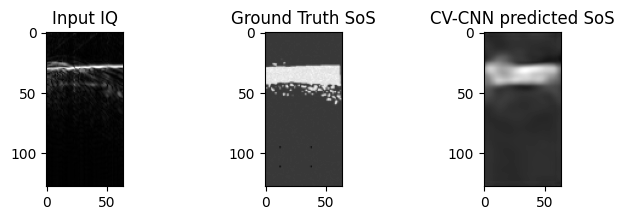

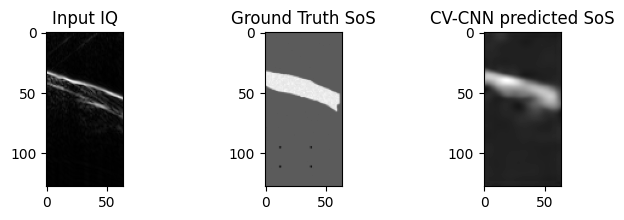

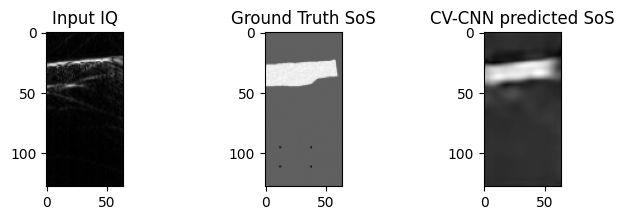

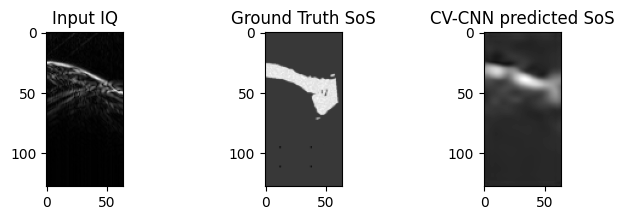

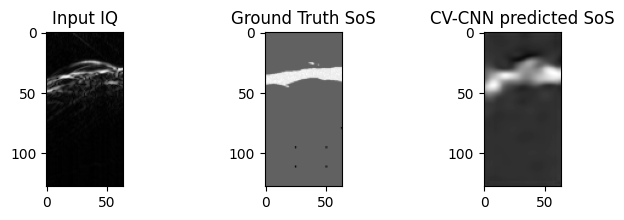

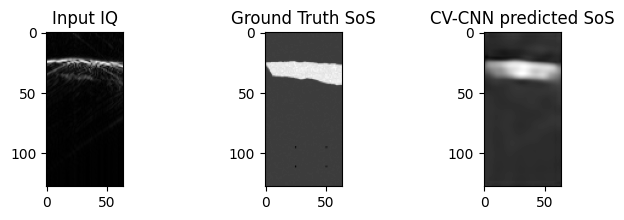

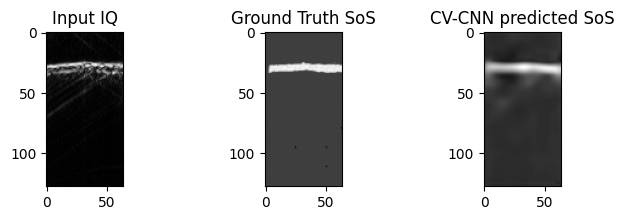

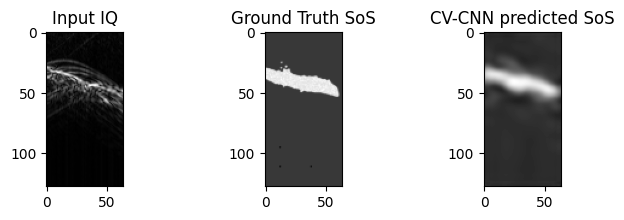

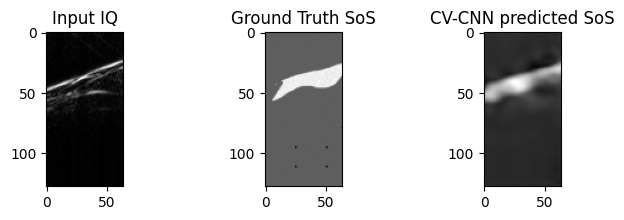

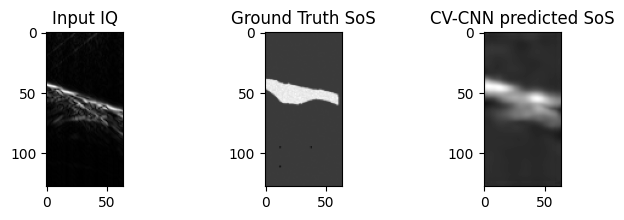

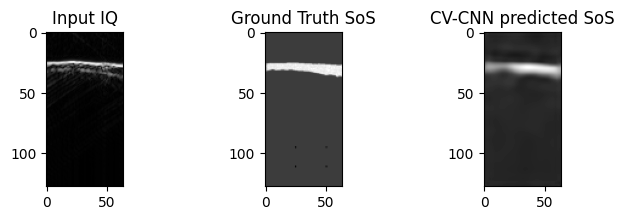

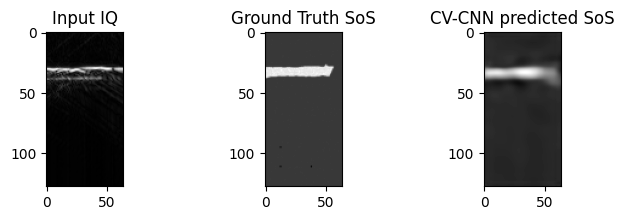

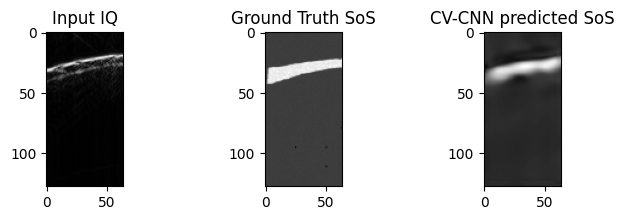

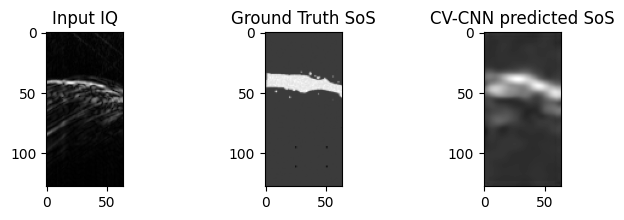

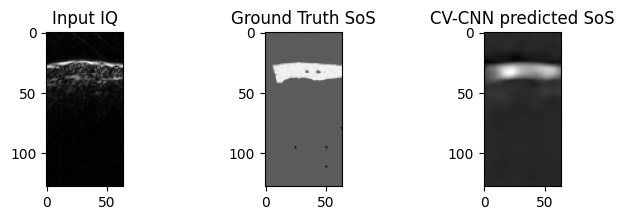

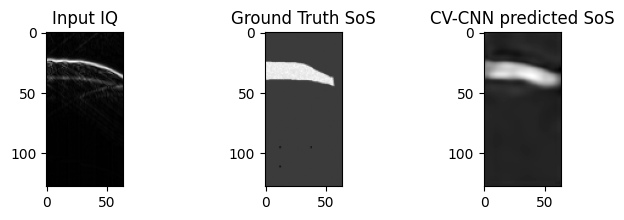

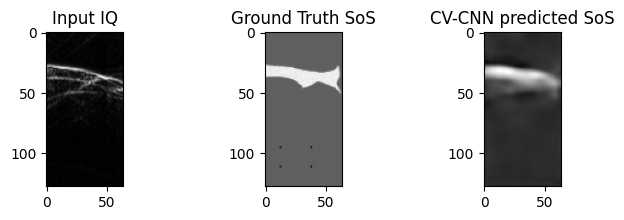

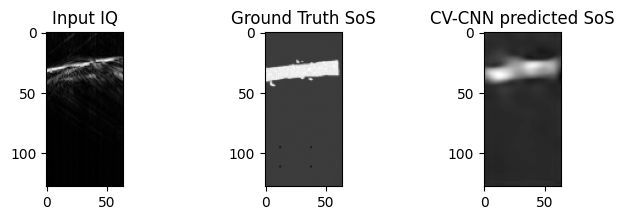

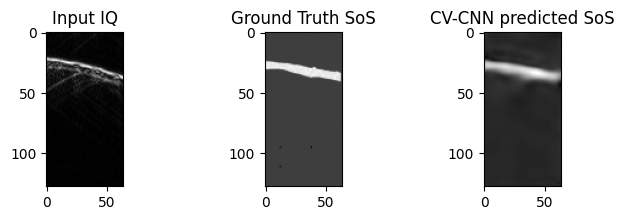

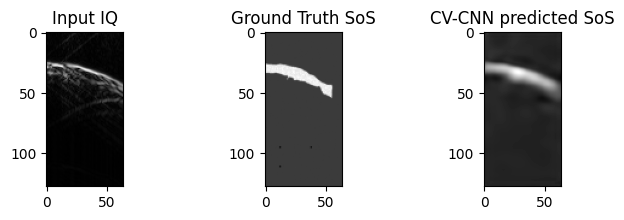

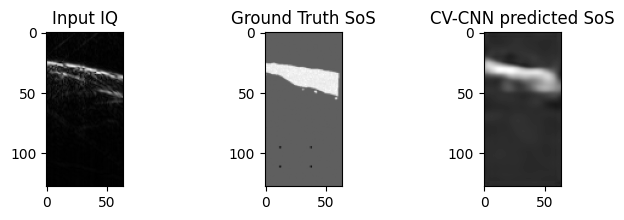

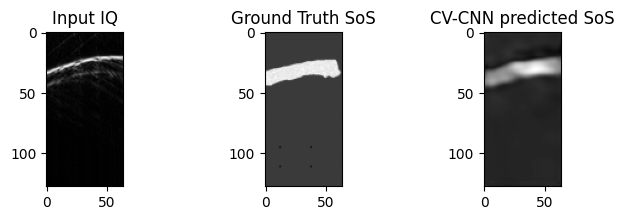

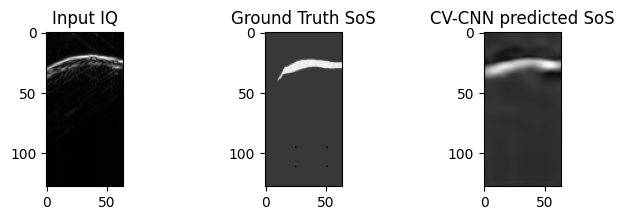

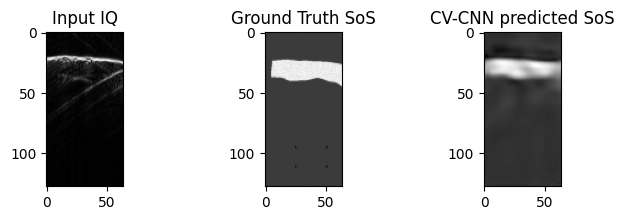

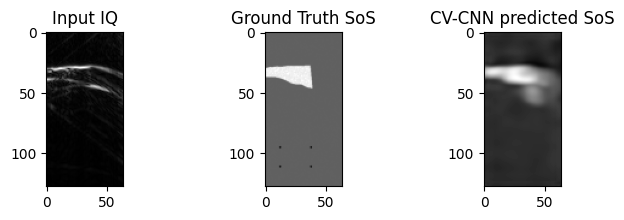

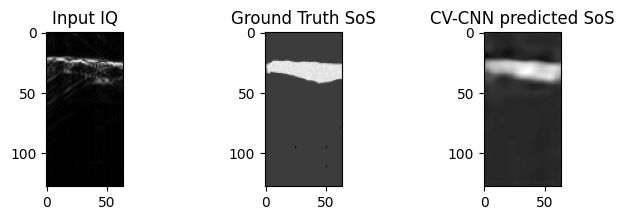

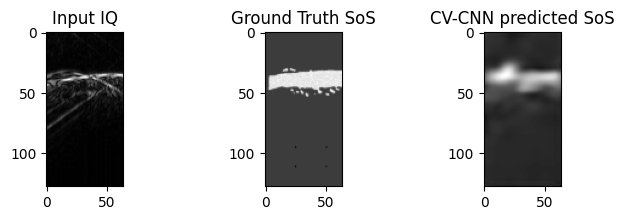

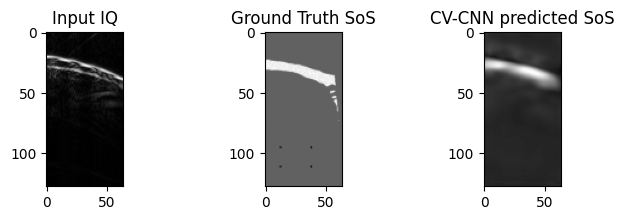

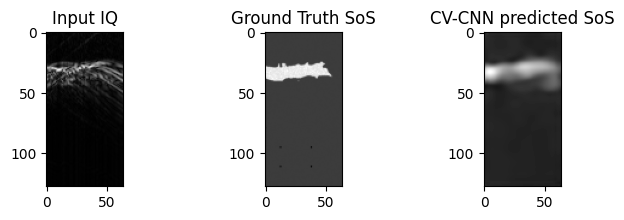

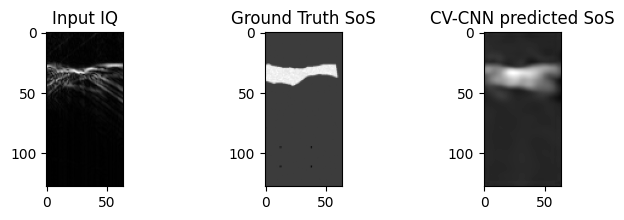

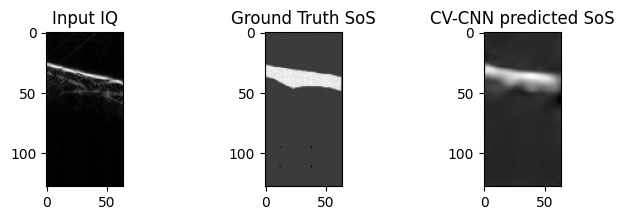

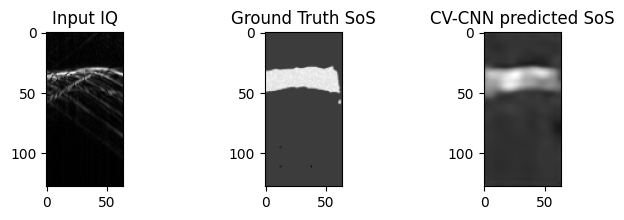

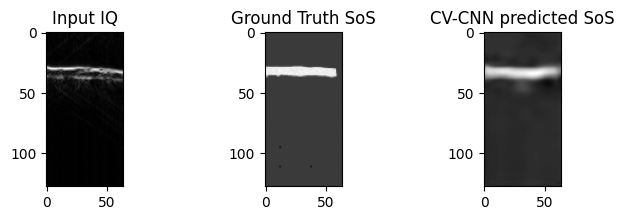

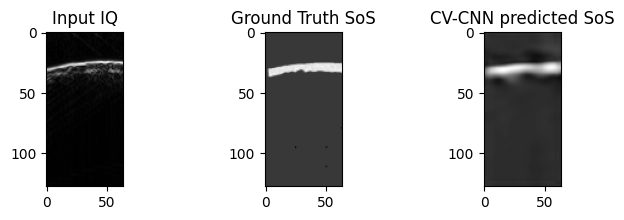

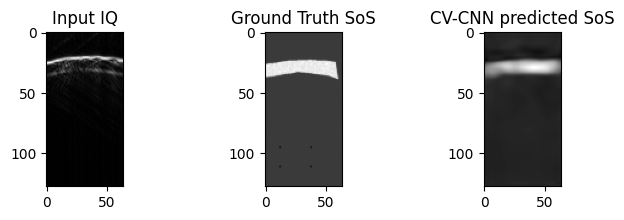

In [53]:
n = 50
#display outputs
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Input IQ')
    im0 = axes[0].imshow(abs(x_test[i]).reshape(dimension_1, dimension_2), cmap = 'gray')
    axes[1].set_title('Ground Truth SoS')
    im1 = axes[1].imshow(abs(y_test[i]).reshape(dimension_1, dimension_2), cmap = 'gray')
    axes[2].set_title('CV-CNN predicted SoS')
    im2 = axes[2].imshow(abs(all_denoised_images[i]).reshape(dimension_1, dimension_2), cmap = 'gray')
    plt.savefig(f'comparison-{i}.png')

In [ ]:
#save outputs
with open('/content/drive/MyDrive/output_sosbf1.pkl', 'wb') as f:
  pickle.dump(all_denoised_images,f)


In [ ]:
#save model
model.save('/content/drive/MyDrive/complex_autoencoder_sosiq1')


In [ ]:
#display history
train_loss = new_history.history['loss']
train_val_loss = new_history.history['val_loss']
ssim_loss = new_history.history['ssim_loss']
psnr_loss = new_history.history['psnr_loss']
val_mse = new_history.history['val_mean_squared_error']
mse = new_history.history['mean_squared_error']
val_ssim_loss = new_history.history['val_ssim_loss']
val_psnr_loss = new_history.history['val_psnr_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, label = 'Val loss')
#plt.plot(epochs, ssim_loss, label = 'ssim loss')
#plt.plot(epochs, psnr_loss, label = 'psnr loss')
plt.plot(epochs, mse, label = 'mse')
plt.plot(epochs, val_mse, label = 'Val mse')
#plt.plot(epochs, val_ssim_loss, label = 'Val ssim loss')
#plt.plot(epochs, val_psnr_loss, label = 'Val psnr loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('/content/drive/MyDrive/historybf1.png')

In [ ]:

plt.figure(dpi = 100)

plt.plot(epochs, ssim_loss, label = 'ssim loss')
#plt.plot(epochs, psnr_loss, label = 'psnr loss')

plt.plot(epochs, val_ssim_loss, label = 'Val ssim loss')
#plt.plot(epochs, val_psnr_loss, label = 'Val psnr loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('/content/drive/MyDrive/history_ssimbf1.png')

In [ ]:

plt.figure(dpi = 100)
plt.plot(epochs, psnr_loss, label = 'psnr loss')


plt.plot(epochs, val_psnr_loss, label = 'Val psnr loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('/content/drive/MyDrive/history_psnrbf1.png')

In [ ]:
with open('/content/drive/MyDrive/historybf1.pkl', 'wb') as f:
  pickle.dump(new_history,f)

In [ ]:
with open('/content/drive/MyDrive/y_testsosbf1.pkl', 'wb') as f:
  pickle.dump(y_test,f)
with open('/content/drive/MyDrive/x_testsosbf1.pkl', 'wb') as f:
  pickle.dump(x_test,f)

In [ ]:
data={'gt':yy,'gt1':yy1,'o':all_denoised_images,'o1':all_denoised_images1}
sio.savemat('/content/drive/MyDrive/iq1output.mat',data)